<small><i>June 2016 - This notebook was created by [Guillem Pascual](http://github.com/gpascualg). Source and [license](./LICENSE.txt) info are in the folder.</i></small>

# Image Colorization

Colorizing an image consists in taking a grayscale image and outputting its corresponding colored version.
We, however, want to do this process fully automated, without any user interaction. 

![Fine Tuning scheme](static/colorization.png)

We will take as reference landscape images and will train a network to colorize them.

## Fine Tuning

But, do we really need to train a new network from scratch? Thinking about it, most networks that perform image classification already have some work done for us:

* They have common filters for objects, background... (Convolutional layers already trained)

* They are proven and work on their own problems

So, what if we took those pre-trained networks and used them in our own network? That is commonly done and is known as *fine tuning*. Its name comes from the concept of borrowing the already learned weights and performing small changes to them so that they fit our own data.

We are, however, not limited to that. We might even take the weights from a well-known network, freeze them so they never change, and add on top of them more layers which we would like to train.

Let's suppose we want to classify 300 different dog breeds, we might take the VGG network, which is trained to perform image classification among 1000 classes, including objects, animals, plants... and fine tune it so that instead of those classes, it learns to differentiate dogs:


![Fine Tuning scheme](static/FineTuning.png)

## Fine tuning in TensorFlow

The main problem is that tensorflow pre-trained models might come in 3 flavours:

* Tensorflow models (*model-name.tfmodel*): It is the most straightforward model, you do not have to define any graph at all as the model itself contains the graph

* Numpy-like models (*model-name.npy*): Unlike the previous one you must manually create all ops, variables and placeholders. However, as everything is written in a python-numpy manner, you can individually access every layers' weights and biases.

* Tensorflow checkpoints (*model-name.ckpt*): As with numpy, you must define the ops, variables and placeholders, but saving the model is fully automated (which isn't with the numpy approach).

Here, we will be using the last two: Numpy for loading the VGG model and checkpoints to save our trained model

# Deep Color

Our problem consist of an input image of size $(256,256)$, as a grayscale image, and we want to output a $(256,256,3)$ RGB image.

To simplify the problem, instead of the RGB color space we will use the L\*a\*b color space, where the *L* channel is the lightning (that is, the grayscale image) and *a* and *b* the color ones. Thus, we reduce the problem to outputting an image of size $(256,256,2)$

The architecture is as follows:

<p style="text-align: center">
    ![DeepColor architecture](static/DeepColor.png)
</p>

## Let's get started

Import all necessary dependencies:

* Tensorflow data loading (Dataset), VGG model definition (Models) and network layers (Network)

* Numpy for fast number operations

* Outputing to stderr (sys)

* Lab -> RGB conversions to display images (scipy.misc, skimage.io, OpenCV2)

* Math operations (math)

* Progress monitoring (datetime, tqdm)

* Image displaying (matplotlib.pyplot, Ipython.display)

* Tensorflow (tensorflow)

In [1]:
from helpers import Dataset
from helpers import Models
from helpers import Network

import numpy as np
import sys
import cv2
import urllib
import math
from scipy import misc
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as display

%matplotlib inline

LMDB Loading won't be available


## L\*a\*b to RGB conversion

In [2]:
# Given the 2 color channels (ab) and the lightning (L, grayscale) displays an image
#   verbose: Output some debug information
#   label: Ground truth (ab channels)
def display_image(ab, L, verbose=False, label=None):
    # L range is 0-120 in lab
    L = L.squeeze() * 120.0
    # ab range is -128,128 in lab
    ab = ab.squeeze() * 128.0
    
    # Concatenate to a single array
    lab = np.dstack((L, ab))

    if verbose:
        print lab[:,:,0].max(), lab[:,:,0].min()
        print lab[:,:,1].max(), lab[:,:,1].min()
        print lab[:,:,2].max(), lab[:,:,2].min()

    # Convert to RGB for display purpouses
    rgb = cv2.cvtColor(lab.astype(np.float32), cv2.COLOR_LAB2RGB)
    
    # Subplot the RGB image and the grayscale (input) image
    fig, ax = plt.subplots(1, 3 if label is not None else 2)
    fig.set_size_inches((8,5))
    ax[0].imshow(L, cmap='gray')
    ax[1].imshow(rgb)
    
    # If given, display the ground truth too
    if label is not None:
        labelRGB = np.dstack((L, label * 128.0))
        labelRGB = cv2.cvtColor(labelRGB.astype(np.float32), cv2.COLOR_LAB2RGB)
    
        ax[2].imshow(labelRGB)
    
    # Display the figure
    display.display(fig)
    plt.close()
    
    return ab, label

def rgb2ab(rgb):
    assert rgb.ndim == 4, "Must be a 4D Tensor"
    
    ab = np.empty((rgb.shape[0], rgb.shape[1], rgb.shape[2], 2))
    for i in range(rgb.shape[0]):
        # Convert to RGB for display purpouses
        Lab = cv2.cvtColor(rgb[i,...].astype(np.float32), cv2.COLOR_RGB2LAB)
        ab[i,...] = Lab[:,:,1:]
        
    return ab

### Dataset loading

For training/testing purpouses we use a big dataset of 25.000 images for training and 5.000 images to test how well the network perfoms

In [3]:
# Batch size, 8 images at once
batch_size = 4
    
# Load dataset
dataset = Dataset.Dataset(config={
    'test': {
        'file_path': 'dataset/colorization.txt',
        'data_path': './dataset/',
        'scale': 1.0/255.0,  # We want a normalized 0-1 range
        'resize': (256, 256)
    },
    'common': {
        'prefetch': 1,
        'batch_size': batch_size,
        'start_prefetch': False
    }
})

dataset.test.start_prefetch().wait_prefetch()

  0%|          | 0/1 [00:00<?, ?it/s]

Prefetching data


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


### DeepColor class

To reduce the code boilerplate and keep everything clean, the whole training and testing of the network is assembled into a single class.

*"Public Methods"*:

* **Train**: Trains the network on a given dataset.
  > **learning_rate**: Optimizer learning rate
  
  > **training_iters**: Number of iterations to train for

  > **test_size**: Number of images to test

  > **dataset**: Dataset to train on

  > **learning_rate_decay** [default=0.97]: Factor to decay ever 1000 iterations

  > **display_step** [default=10]: Number of iterations between each loss display

  > **test_step** [default=50]: Number of iterations between tests

  > **save_step** [default=500]: Number of iterations between checkpoints (if save_path is not None)

  > **clear_step** [default=2000]: Number of iterations between ipython cell's clear

  > **save_path** [default=None]: If not None, the path where checkpoints are created

* **Test**: Given a dataset with *test* images, it forwards them through the image
  > **dataset**: Dataset to test on

  > **num_batches**: How many batches (each of *batch_size*) to test

  > **model_path**: The path to the trained model to load

In [4]:
class DeepColor(object):
    
    def __init__(self, batch_size, device='/gpu:1'):
        # As we will be using the default tensorflow graph, we want to make sure 
        # to clear it every time we execute it, otherwise we will get duplicate
        # variables errors
        tf.reset_default_graph()

        self.batch_size = batch_size
        self.device = device
        self.created = False
        
        # By default use:
        #   padding: SAME (whole size)
        #   weight_decay: 0.0005 (L2 weight normalization)
        #   device: /gpu:1
        with Network.Defaults(padding='SAME', wd=None, device=self.device):
            # Graph input
            self.x = tf.placeholder(tf.float32, [batch_size, 256, 256, 1])
            self.y = tf.placeholder(tf.float32, [None, 256, 256, 2])
            self.phase_train = tf.placeholder(tf.bool, name='phase_train')

            # As VGG has RGB images as input, copy the grayscale image 3 times
            with tf.variable_scope('wrapper', initializer=tf.constant_initializer(1)):
                copy_img = Network.conv(self.x, 1, 1, 3, 1, 1, name='copy_img', trainable=False)

            # Load the VGG ops and variables
            model_output, model = Models.vgg16_small(copy_img, trainable=False)

            # Color network, resnet-like
            with tf.variable_scope('color', initializer=tf.uniform_unit_scaling_initializer(1.15)):
                # Bridge convolution
                bridge = Network.conv(model_output, 1, 1, 1024, 1, 1, name='bridge')
                bridge = Network.conv(bridge, 3, 3, 256, 1, 1, name='bridge-conv')

                # All the upsampling process
                upsample4 = self.upsample(bridge, 'upsample4', (32, 32), 512, model['conv4_1'])
                upsample3 = self.upsample(upsample4, 'upsample3', (64, 64), 256, model['conv3_1'])
                upsample2 = self.upsample(upsample3, 'upsample2', (128, 128), 128, model['conv2_1'])
                upsample1 = self.upsample(upsample2, 'upsample1', (256, 256), 64, model['conv1_1'])
                
                # Make the prediction
                postres1 = Network.conv(upsample1, 3, 3, 32, 1, 1, name='postres1')
                self.pred = Network.conv(postres1, 1, 1, 2, 1, 1, name='pred', relu=False)
                        
                # Image loss
                tf.add_to_collection('losses', tf.reduce_mean(tf.square(self.pred - self.y)))

            # Final loss            
            self.loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
    
    # Upsampling process
    def upsample(self, x, name, image_size, output_size, model_layer):
        with tf.variable_scope(name):
            # Upsample the image
            upsample = tf.image.resize_nearest_neighbor(x, image_size)
            # Convolve before summing
            presum = Network.conv(upsample, 3, 3, output_size, 1, 1, name='presum')
            # Batch normalize the VGG output
            norm = Network.batch_norm(model_layer, output_size, self.phase_train, name="norm")        
            # Sum both layers
            summation = tf.add(norm, presum)
            # Convolve again
            output = Network.conv(summation, 3, 3, output_size / 2.0, 1, 1, name='postsum')
            return output
    
    def now(self):
        return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    def train(self, learning_rate, training_iters, test_size, dataset, 
              learning_rate_decay=0.97, display_step=10, test_step=50, save_step=500,
              clear_step=2000, save_path=None):
        
        with Network.Defaults(padding='SAME', wd=None, device=self.device):        
            # Learning rate decaying
            with tf.device('/cpu:0'):
                global_step = tf.Variable(0, trainable=False)
                learning_rate = tf.train.exponential_decay(learning_rate, global_step, 1000, 
                                                           learning_rate_decay, staircase=False)

            # Loss and optimizer
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=1.0)
            optimizer = optimizer.minimize(self.loss, global_step=global_step)

            # Init
            init = tf.initialize_all_variables()

            # Saver (create checkpoints)
            with tf.device('/cpu:0'):
                saver = tf.train.Saver()

            # Launch the graph
            with tf.Session() as sess:
                # Initialize all variables
                print 'Init variables'
                sess.run(init)

                # Load the VGG model
                print 'Loading VGG model'
                Network.load_with_skip('vgg16.npy', sess, ['conv3_3', 'conv4_3', 'conv5_3', 'fc6','fc7','fc8']) 

                # Start the learning process
                print 'Start training'
                for step in tqdm(range(1, training_iters)):
                    # Step
                    batch_xs, batch_ys = dataset.train.next_batch()
                    sess.run(optimizer, feed_dict={self.x: batch_xs, self.y: batch_ys, self.phase_train: True})            

                    # Clear current cell
                    if step % clear_step == 0:
                        display.clear_output(wait=False)
                        
                    # Display testing status
                    if step % test_step == 0:
                        print >> sys.stderr, " - {} Iter {}: Testing".format(self.now(), step)

                        test_loss = 0.0
                        test_count = 0
                        dataset.test.reset()
                        
                        num_items = 1 if test_size < self.batch_size else np.ceil(test_size/self.batch_size)

                        for _ in range(int(num_items)):
                            batch_tx, batch_ty = dataset.test.next_batch()

                            feed_dict = {self.x: batch_tx, self.y: batch_ty,  self.phase_train: False}
                            ab, batch_loss = sess.run([self.pred, self.loss], feed_dict=feed_dict)

                            test_loss += batch_loss
                            test_count += 1

                            for i in range(self.batch_size):
                                display_image(ab[i, :, :, :], batch_tx[i, :, :, :], label=batch_ty[i, :, :, :])

                        msg = " > {} Iter {}: Testing Loss = {:.6f}"
                        msg = msg.format(self.now(), step + 1, test_loss / test_count)
                        print >> sys.stderr, msg
                        
                    # Display training status
                    if (step + 1) % display_step == 0:
                        feed_dict = {self.x: batch_xs, self.y: batch_ys, self.phase_train: False}
                        ab, batch_loss, lr = sess.run([self.pred, self.loss, learning_rate], feed_dict=feed_dict)

                        msg = " - {} Iter {}: Training [LR={:.4f}, Loss={:.6f}]"
                        msg = msg.format(self.now(), step + 1, lr, batch_loss)
                        print >> sys.stderr, msg

                    # Save model
                    if (step + 1) % save_step == 0 and save_path is not None:
                        print >> sys.stderr, " - {} Iter {}: Saving".format(self.now(), step + 1)

                        # Save the variables to disk.
                        saved_path = saver.save(sess, save_path, global_step=step + 1)
                        
                        msg = " - {} Iter {}: Saved as {}"
                        msg = msg.format(self.now(), step + 1, saved_path)
                        print >> sys.stderr, msg

                print "Finish!"
                
    def __build_test(self, model_path):
        if not self.created:
            self.created = True

            # Saver (create checkpoints)
            with tf.device('/cpu:0'):
                saver = tf.train.Saver()
                
            self.sess = tf.Session()
            
            print 'Init variables'
            saver.restore(self.sess, model_path)
            

    # Test the net without training
    def test(self, dataset, num_batches, model_path=None, show_label=False):
        with Network.Defaults(padding='SAME', wd=None, device=self.device):
            self.__build_test(model_path)

            print 'Start test'
            for _ in range(num_batches):
                batch_tx, batch_ty = dataset.test.next_batch()

                # Save original as target (y)
                batch_ty = rgb2ab(batch_tx)

                # Convert image to grayscale
                batch_tx = np.mean(batch_tx, axis=3)[:,:,:,np.newaxis] # Also, add a new axis 1, 4D Tensor

                # Show all results
                self.__show_test(batch_tx, batch_ty, self.batch_size, show_label)

            print "Finish!"
            
    # Test the net without training and using a single image
    def test_image(self, path, model_path=None, show_label=False):
        self.__test_single(misc.imread(path).astype(np.float32) / 255.0, model_path, show_label)
                
    # Test the net without training and downloading an image
    def test_online(self, url, model_path=None, show_label=False):
        resp = urllib.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        self.__test_single(image.astype(np.float32) / 255.0, model_path, show_label)
                
    # Test the net without training and using a single image
    def __test_single(self, image, model_path=None, show_label=False):
        with Network.Defaults(padding='SAME', wd=None, device=self.device):
            self.__build_test(model_path)

            print 'Start test'            
            # Create input variables
            batch_tx = np.empty((self.batch_size, 256, 256, 1))
            batch_ty = np.empty((self.batch_size, 256, 256, 2))
            
            # Read the image and convert to ab appropiately
            batch_ty[0, ...] = rgb2ab(image[np.newaxis])
            batch_tx[0, ...] = np.mean(image, axis=2)[np.newaxis][:,:,:,np.newaxis]
            
            # Show results
            self.__show_test(batch_tx, batch_ty, 1, show_label)

            print "Finish!"
            
    def __show_test(self, batch_tx, batch_ty, num, show_label=False):
        # Feed to the network
        feed_dict = {self.x: batch_tx, self.y: batch_ty, self.phase_train: False}
        ab = self.sess.run(self.pred, feed_dict=feed_dict)

        # Show results
        for i in range(num):
            label = None if show_label is False else batch_ty[i, :, :, :]
            display_image(ab[i, :, :, :], batch_tx[i, :, :, :], label=label)
        
            
    def close(self):
        if self.created:
            self.sess.close()
            self.created = False

### Create the network

In [5]:
net = DeepColor(batch_size=batch_size, device='/cpu:0')
model_path = '../color-model-40000.ckpt'

### Test the network

Init variables
Start test


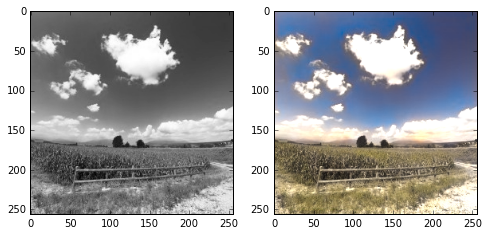

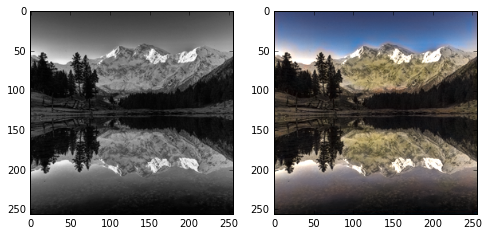

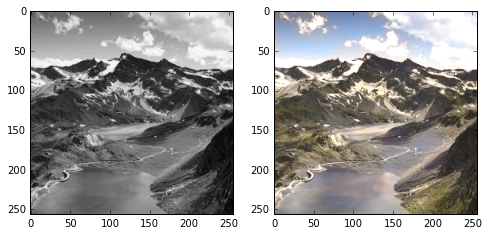

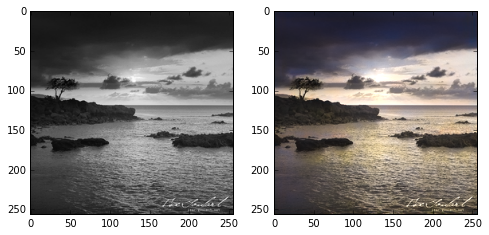

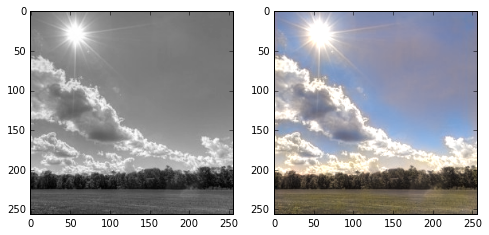

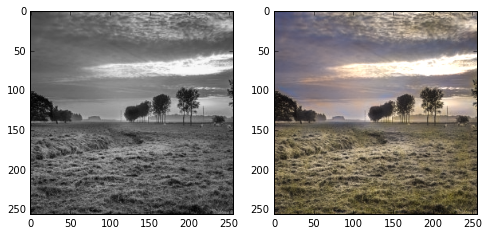

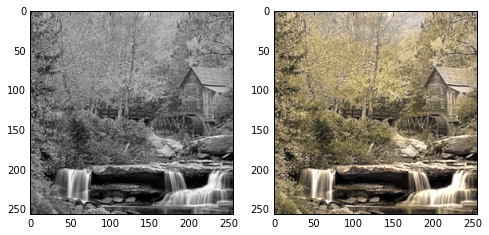

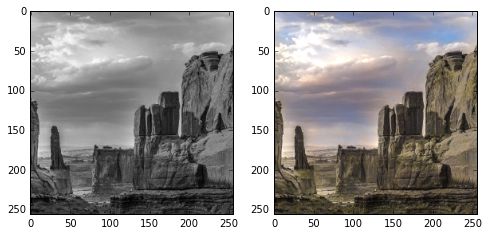

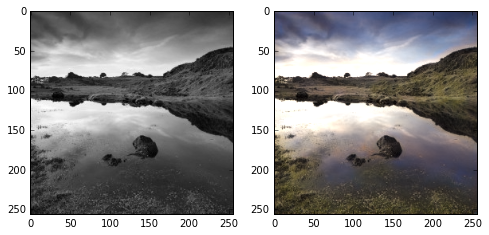

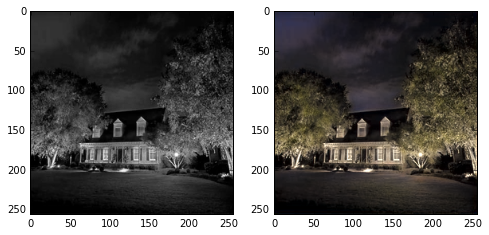

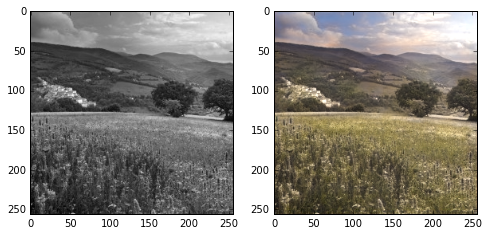

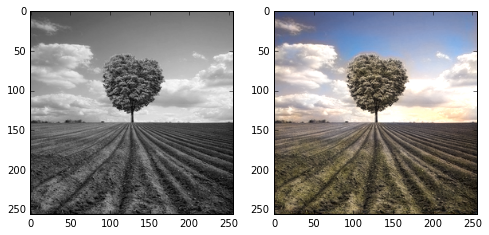

Finish!


In [6]:
net.test(dataset=dataset, num_batches=3, model_path=model_path)

Start test


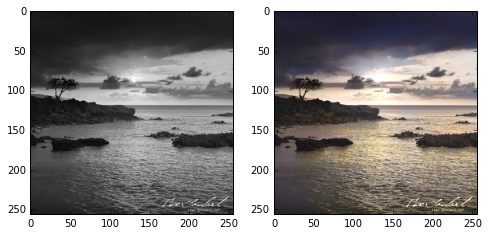

Finish!


In [7]:
net.test_image('dataset/colorization/1.jpg', model_path=model_path)

Start test


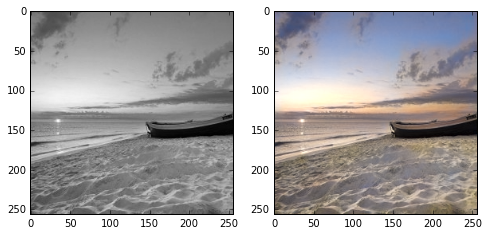

Finish!


In [8]:
net.test_online('http://wallpaper.sc/en/ipad/wp-content/uploads/2014/10/ipad-2048x2048-thumbnail_00233-256x256.jpg',
               model_path=model_path)

### Close the session

In [9]:
net.close()